Data Loading and Exploration of Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('stroke_dataset.csv')
print(f"Initial dataset shape: {data.shape}")

print("\nFirst Few Rows:")
print(data.head())

print("\nDataset Info:")
print(data.info())

print("\nUnique Values:")
print(data.nunique())

print("\nStatistical Summary:")
print(data.describe())

print("\nMissing Values:")
print(data.isnull().sum())


print("\nTarget Variable Distribution:")
print(data['stroke'].value_counts())
print(f"\nClass Imbalance Ratio: {data['stroke'].value_counts()[0]/data['stroke'].value_counts()[1]:.2f}:1")


Initial dataset shape: (5110, 12)

First Few Rows:
      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  

Data

EDA

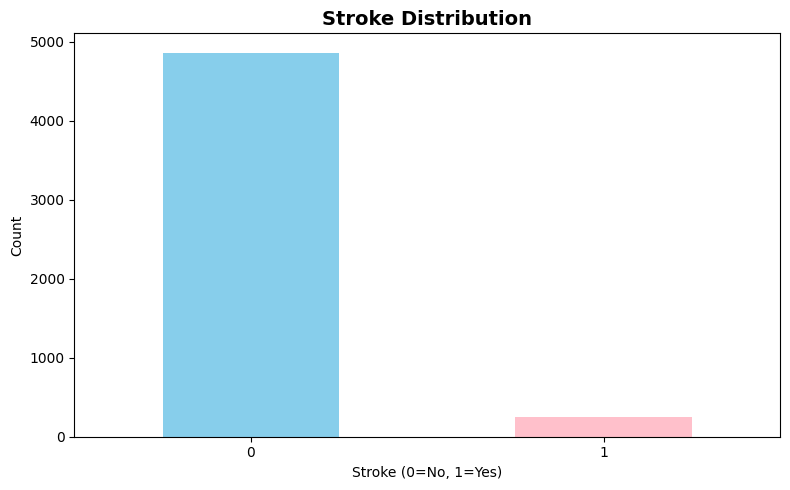

In [4]:
# Target Distribution
plt.figure(figsize=(8, 5))
data['stroke'].value_counts().plot(kind='bar', color=['skyblue', 'pink'])
plt.title('Stroke Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Stroke (0=No, 1=Yes)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

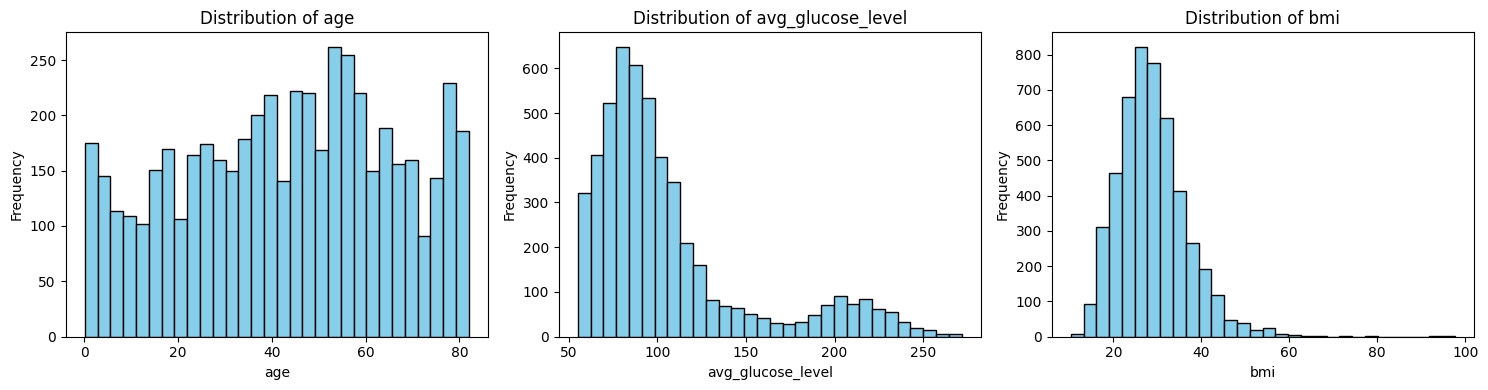

In [5]:
# Numerical Features Distribution
numerical_cols = ['age', 'avg_glucose_level', 'bmi']
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, col in enumerate(numerical_cols):
    axes[idx].hist(data[col].dropna(), bins=30, color='skyblue', edgecolor='black')
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64


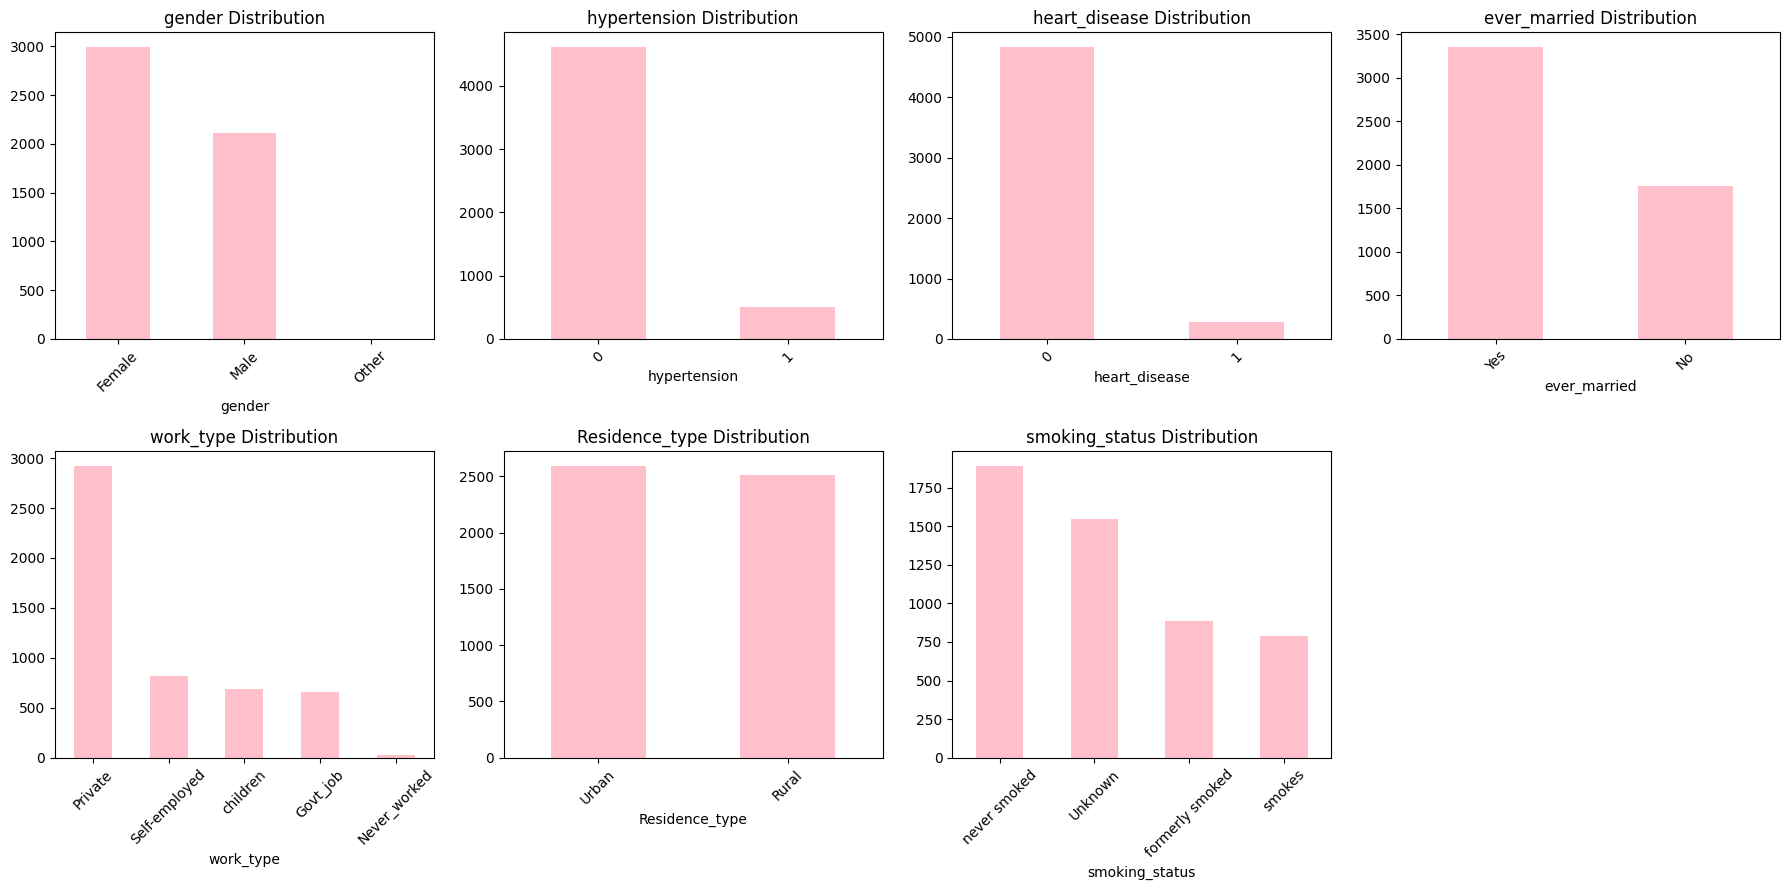

In [6]:
# Categorical Features 
categorical_cols = ['gender', 'hypertension', 'heart_disease', 'ever_married', 
                   'work_type', 'Residence_type', 'smoking_status']

print(data['gender'].value_counts())

fig, axes = plt.subplots(2, 4, figsize=(18, 9))
axes = axes.flatten()
for idx, col in enumerate(categorical_cols):
    data[col].value_counts().plot(kind='bar', ax=axes[idx], color='pink')
    axes[idx].set_title(f'{col} Distribution')
    axes[idx].set_xlabel(col)
    axes[idx].tick_params(axis='x', rotation=45)
axes[-1].axis('off')
plt.tight_layout()
plt.show()

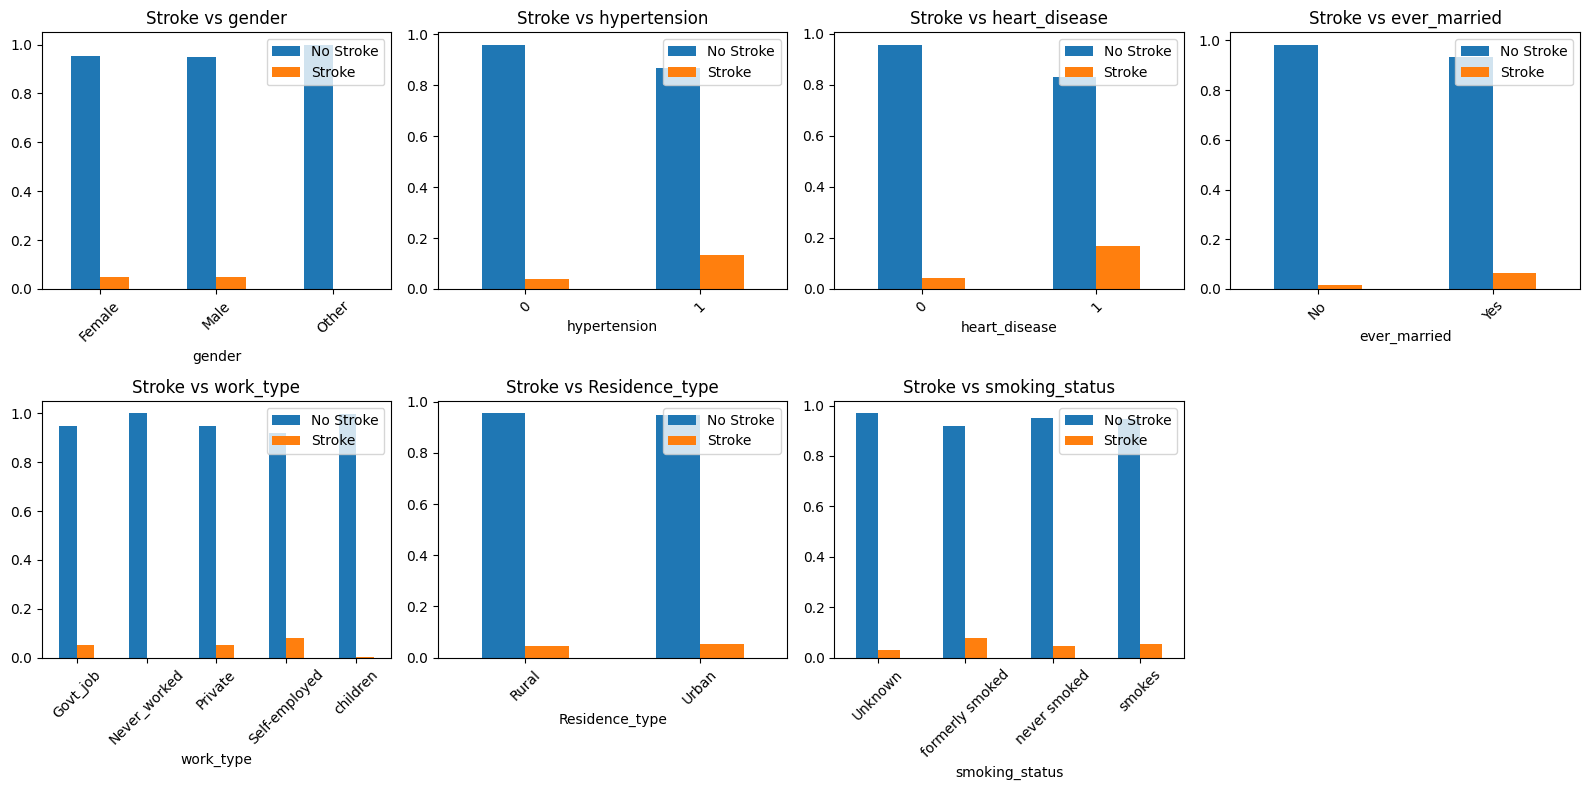

In [7]:
# Correlation with Target
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()
for idx, col in enumerate(categorical_cols):
    pd.crosstab(data[col], data['stroke'], normalize='index').plot(kind='bar', ax=axes[idx], stacked=False)
    axes[idx].set_title(f'Stroke vs {col}')
    axes[idx].legend(['No Stroke', 'Stroke'])
    axes[idx].tick_params(axis='x', rotation=45)
axes[-1].axis('off')
plt.tight_layout()
plt.show()

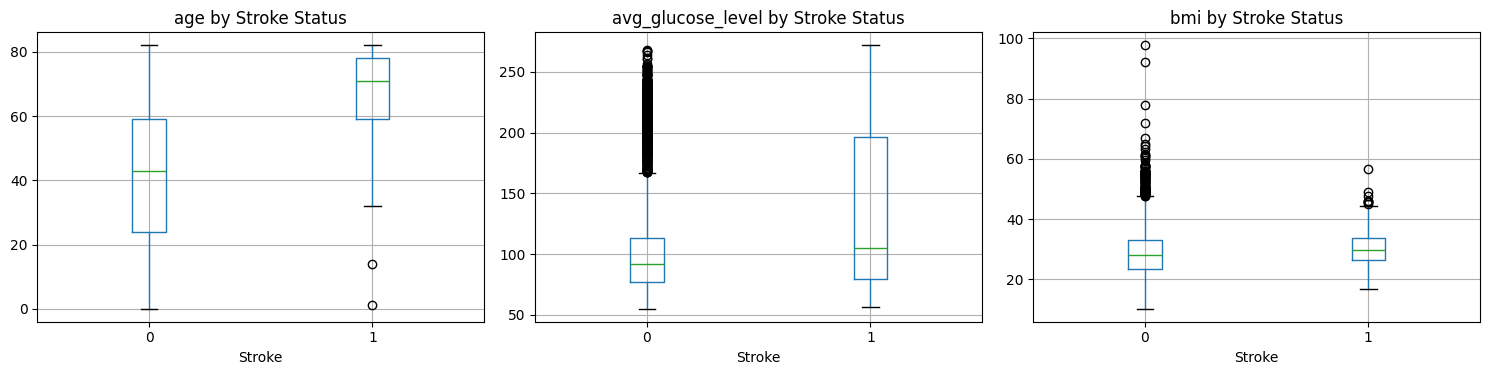

In [8]:
# outliers
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, col in enumerate(numerical_cols):
    data.boxplot(column=col, by='stroke', ax=axes[idx])
    axes[idx].set_title(f'{col} by Stroke Status')
    axes[idx].set_xlabel('Stroke')
plt.suptitle('')
plt.tight_layout()
plt.show()

Data Preprocessing

In [10]:
data_cleaned = data.copy()

In [11]:
# drop "id" column
data_cleaned = data_cleaned.drop('id', axis=1)

In [12]:
# handle missing values in "bmi" column
from sklearn.impute import SimpleImputer

print(f"\nMissing BMI values: {data_cleaned['bmi'].isnull().sum()}")
bmi_imputer = SimpleImputer(strategy='median') # impute with median
data_cleaned['bmi'] = bmi_imputer.fit_transform(data_cleaned[['bmi']])


Missing BMI values: 201


In [13]:
# remove rows with "others" in gender column (because 1 row only)
data_cleaned = data_cleaned[data_cleaned['gender'] != 'Other']
print(f"Removed 'Other' gender rows. New shape: {data_cleaned.shape}")

Removed 'Other' gender rows. New shape: (5109, 11)


In [14]:
print(f"\nSmoking status distribution:")
print(data_cleaned['smoking_status'].value_counts())


Smoking status distribution:
smoking_status
never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: count, dtype: int64


In [15]:
# identify and handle outliers
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# outliers in glucose level
outliers_glucose, lb_g, ub_g = detect_outliers_iqr(data_cleaned, 'avg_glucose_level')
print(f"\nOutliers in glucose level: {len(outliers_glucose)} ({len(outliers_glucose)/len(data_cleaned)*100:.2f}%)")

# outliers in BMI
outliers_bmi, lb_b, ub_b = detect_outliers_iqr(data_cleaned, 'bmi')
print(f"Outliers in BMI: {len(outliers_bmi)} ({len(outliers_bmi)/len(data_cleaned)*100:.2f}%)")


Outliers in glucose level: 627 (12.27%)
Outliers in BMI: 126 (2.47%)


In [16]:
# feature engineering

# age groups
data_cleaned['age_group'] = pd.cut(data_cleaned['age'], 
                                   bins=[0, 18, 35, 50, 65, 100],
                                   labels=['child', 'young_adult', 'middle_age', 'senior', 'elderly'])

# BMI categories
data_cleaned['bmi_category'] = pd.cut(data_cleaned['bmi'],
                                      bins=[0, 18.5, 25, 30, 100],
                                      labels=['underweight', 'normal', 'overweight', 'obese'])

# glucose level categories
data_cleaned['glucose_category'] = pd.cut(data_cleaned['avg_glucose_level'],
                                          bins=[0, 100, 126, 300],
                                          labels=['normal', 'prediabetic', 'diabetic'])

# Risk score
data_cleaned['risk_score'] = (
    data_cleaned['age'] * 0.3 +
    data_cleaned['hypertension'] * 20 +
    data_cleaned['heart_disease'] * 25 +
    data_cleaned['avg_glucose_level'] * 0.2 +
    data_cleaned['bmi'] * 0.5
)

# interaction features
data_cleaned['age_glucose'] = data_cleaned['age'] * data_cleaned['avg_glucose_level']
data_cleaned['age_bmi'] = data_cleaned['age'] * data_cleaned['bmi']

In [17]:
# encode categorical variables
data_before_encoding = data_cleaned.copy()

# binary encoding for binary categories
binary_mappings = {
    'gender': {'Male': 1, 'Female': 0},
    'ever_married': {'Yes': 1, 'No': 0},
    'Residence_type': {'Urban': 1, 'Rural': 0}
}

for col, mapping in binary_mappings.items():
    data_cleaned[col] = data_cleaned[col].map(mapping)
    print(f"Binary encoded: {col}")

# one-hot encoding for multi-category features
categorical_to_encode = ['work_type', 'smoking_status', 'age_group', 
                         'bmi_category', 'glucose_category']

data_cleaned = pd.get_dummies(data_cleaned, columns=categorical_to_encode, 
                              prefix=categorical_to_encode, drop_first=True)
print(f"One-hot encoded: {categorical_to_encode}")

print(f"\nFinal preprocessed shape: {data_cleaned.shape}")
print(f"Features after preprocessing: {data_cleaned.shape[1] - 1}")

Binary encoded: gender
Binary encoded: ever_married
Binary encoded: Residence_type
One-hot encoded: ['work_type', 'smoking_status', 'age_group', 'bmi_category', 'glucose_category']

Final preprocessed shape: (5109, 28)
Features after preprocessing: 27


Train Test Spilt

In [19]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# separate features and target
X = data_cleaned.drop('stroke', axis=1)
y = data_cleaned['stroke']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution:\n{y.value_counts()}")

# split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"\nTrain set: {X_train.shape}, Stroke cases: {y_train.sum()}")
print(f"Test set: {X_test.shape}, Stroke cases: {y_test.sum()}")

# feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled using StandardScaler")

# store feature names for later use
feature_names = X.columns.tolist()
print(f"\nTotal features: {len(feature_names)}")

Features shape: (5109, 27)
Target shape: (5109,)
Target distribution:
stroke
0    4860
1     249
Name: count, dtype: int64

Train set: (4087, 27), Stroke cases: 199
Test set: (1022, 27), Stroke cases: 50

Features scaled using StandardScaler

Total features: 27


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

# Baseline classifiers to compare
baseline_models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ),
    "Decision Tree": DecisionTreeClassifier(
        random_state=RANDOM_STATE,
        class_weight="balanced"
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        random_state=RANDOM_STATE
    ),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "SVM (RBF)": SVC(
        kernel="rbf",
        probability=True,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ),
    "Naive Bayes": GaussianNB()
}

baseline_results = []

for name, model in baseline_models.items():
    try:
        model.fit(X_train_scaled, y_train)


        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test_scaled)[:, 1]
        else:
            y_proba = model.decision_function(X_test_scaled)

        y_pred = model.predict(X_test_scaled)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc = roc_auc_score(y_test, y_proba)

        baseline_results.append({
            "Model": name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1": f1,
            "ROC_AUC": auc
        })

        print(f"\n{name}")
        print(f"  Accuracy : {acc:.4f}")
        print(f"  Precision: {prec:.4f}")
        print(f"  Recall   : {rec:.4f}")
        print(f"  F1-score : {f1:.4f}")
        print(f"  ROC-AUC  : {auc:.4f}")

    except Exception as e:
        print(f"\n{name} failed with error: {e}")

baseline_df = pd.DataFrame(baseline_results).sort_values(
    by="ROC_AUC", ascending=False
)
print("\nSummary of baseline models (sorted by ROC-AUC):")
display(baseline_df)



Logistic Regression
  Accuracy : 0.7025
  Precision: 0.1220
  Recall   : 0.8200
  F1-score : 0.2124
  ROC-AUC  : 0.8370

Decision Tree
  Accuracy : 0.9149
  Precision: 0.1754
  Recall   : 0.2000
  F1-score : 0.1869
  ROC-AUC  : 0.5758

Random Forest
  Accuracy : 0.9501
  Precision: 0.0000
  Recall   : 0.0000
  F1-score : 0.0000
  ROC-AUC  : 0.7815

Gradient Boosting
  Accuracy : 0.9472
  Precision: 0.0000
  Recall   : 0.0000
  F1-score : 0.0000
  ROC-AUC  : 0.8083

K-Nearest Neighbors
  Accuracy : 0.9462
  Precision: 0.0000
  Recall   : 0.0000
  F1-score : 0.0000
  ROC-AUC  : 0.6354

SVM (RBF)
  Accuracy : 0.7544
  Precision: 0.1208
  Recall   : 0.6400
  F1-score : 0.2032
  ROC-AUC  : 0.7643

Naive Bayes
  Accuracy : 0.4168
  Precision: 0.0748
  Recall   : 0.9600
  F1-score : 0.1387
  ROC-AUC  : 0.8181

Summary of baseline models (sorted by ROC-AUC):


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression,0.702544,0.122024,0.82,0.212435,0.837037
6,Naive Bayes,0.416830,0.074766,0.96,0.138728,0.818086
3,Gradient Boosting,0.947162,0.000000,0.00,0.000000,0.808313
2,Random Forest,0.950098,0.000000,0.00,0.000000,0.781523
5,SVM (RBF),0.754403,0.120755,0.64,0.203175,0.764280
4,K-Nearest Neighbors,0.946184,0.000000,0.00,0.000000,0.635422
1,Decision Tree,0.914873,0.175439,0.20,0.186916,0.575823


Class Imbalance Handling

Original training distribution:
Class 0 (No Stroke): 3888
Class 1 (Stroke): 199
Imbalance ratio: 19.54:1

After SMOTE:
Class 0 (No Stroke): 3888
Class 1 (Stroke): 1944
New imbalance ratio: 2.00:1


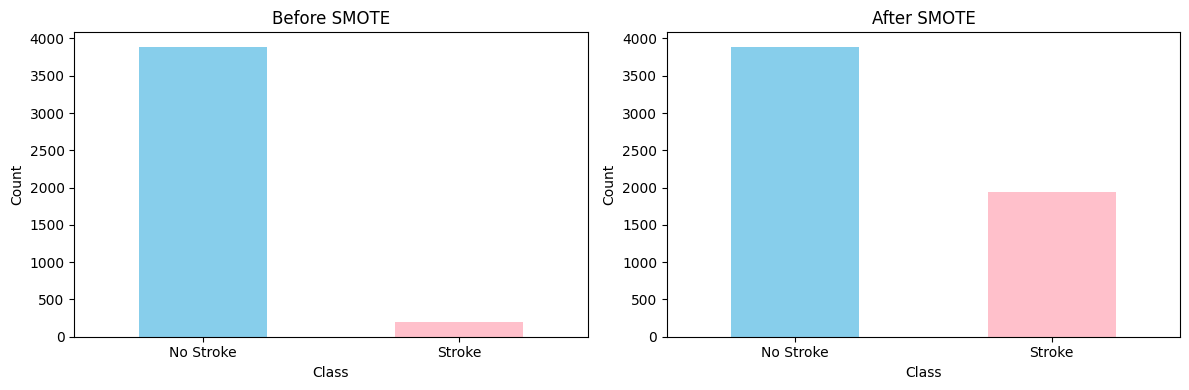

In [22]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# original
print(f"Original training distribution:")
print(f"Class 0 (No Stroke): {(y_train == 0).sum()}")
print(f"Class 1 (Stroke): {(y_train == 1).sum()}")
print(f"Imbalance ratio: {(y_train == 0).sum() / (y_train == 1).sum():.2f}:1")

# apply SMOTE
smote = SMOTE(random_state=RANDOM_STATE, sampling_strategy=0.5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"\nAfter SMOTE:")
print(f"Class 0 (No Stroke): {(y_train_balanced == 0).sum()}")
print(f"Class 1 (Stroke): {(y_train_balanced == 1).sum()}")
print(f"New imbalance ratio: {(y_train_balanced == 0).sum() / (y_train_balanced == 1).sum():.2f}:1")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
pd.Series(y_train).value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'pink'])
axes[0].set_title('Before SMOTE')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['No Stroke', 'Stroke'], rotation=0)

pd.Series(y_train_balanced).value_counts().plot(kind='bar', ax=axes[1], color=['skyblue', 'pink'])
axes[1].set_title('After SMOTE')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['No Stroke', 'Stroke'], rotation=0)
plt.tight_layout()
plt.show()

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                            roc_auc_score, roc_curve, precision_recall_curve,
                            f1_score, accuracy_score, precision_score, recall_score)
from sklearn.model_selection import RandomizedSearchCV

# baseline model
rf_baseline = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
rf_baseline.fit(X_train_balanced, y_train_balanced)

# predictions using baseline model
y_pred_rf_baseline = rf_baseline.predict(X_test_scaled)
y_pred_proba_rf_baseline = rf_baseline.predict_proba(X_test_scaled)[:, 1]

# evaluation
print("\nBaseline Random Forest Results:")
print(classification_report(y_test, y_pred_rf_baseline))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_baseline):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_rf_baseline):.4f}")

# Hyperparameter tuning with randomizedsearchcv
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
}
rf_grid = RandomizedSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    param_distributions=param_grid_rf,
    n_iter=20,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)
rf_grid.fit(X_train_balanced, y_train_balanced)

print(f"\nBest parameters: {rf_grid.best_params_}")
print(f"Best cross-validation score: {rf_grid.best_score_:.4f}")
# final tuned model
rf_tuned = rf_grid.best_estimator_
y_pred_rf_tuned = rf_tuned.predict(X_test_scaled)
y_pred_proba_rf_tuned = rf_tuned.predict_proba(X_test_scaled)[:, 1]

print("\nTuned Random Forest Results:")
print(classification_report(y_test, y_pred_rf_tuned))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_tuned):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_rf_tuned):.4f}")


Baseline Random Forest Results:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       972
           1       0.19      0.10      0.13        50

    accuracy                           0.94      1022
   macro avg       0.57      0.54      0.55      1022
weighted avg       0.92      0.94      0.93      1022

Accuracy: 0.9354
ROC-AUC Score: 0.7777
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Best cross-validation score: 0.9950

Tuned Random Forest Results:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       972
           1       0.23      0.10      0.14        50

    accuracy                           0.94      1022
   macro avg       0.59      0.54      0.55      1022
weighted avg       0.92      0.94      0.93      1022

Accuracy: 0.9393

In [24]:
# Predictions
y_pred_rf = rf_tuned.predict(X_test_scaled)
y_proba_rf = rf_tuned.predict_proba(X_test_scaled)[:, 1]

# Metrics
acc  = accuracy_score(y_test, y_pred_rf)
prec = precision_score(y_test, y_pred_rf, zero_division=0)
rec  = recall_score(y_test, y_pred_rf, zero_division=0)
f1   = f1_score(y_test, y_pred_rf, zero_division=0)
auc  = roc_auc_score(y_test, y_proba_rf)

print("Random Forest Evaluation Metrics")
print("-" * 40)
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC-AUC  : {auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Evaluation Metrics
----------------------------------------
Accuracy : 0.9393
Precision: 0.2273
Recall   : 0.1000
F1-score : 0.1389
ROC-AUC  : 0.7926

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       972
           1       0.23      0.10      0.14        50

    accuracy                           0.94      1022
   macro avg       0.59      0.54      0.55      1022
weighted avg       0.92      0.94      0.93      1022

Confusion Matrix:
[[955  17]
 [ 45   5]]


              feature  importance
1                 age    0.153542
10            age_bmi    0.110474
9         age_glucose    0.096953
8          risk_score    0.078397
7                 bmi    0.062462
6   avg_glucose_level    0.060929
21  age_group_elderly    0.057546
5      Residence_type    0.041884
0              gender    0.041233
12  work_type_Private    0.034484


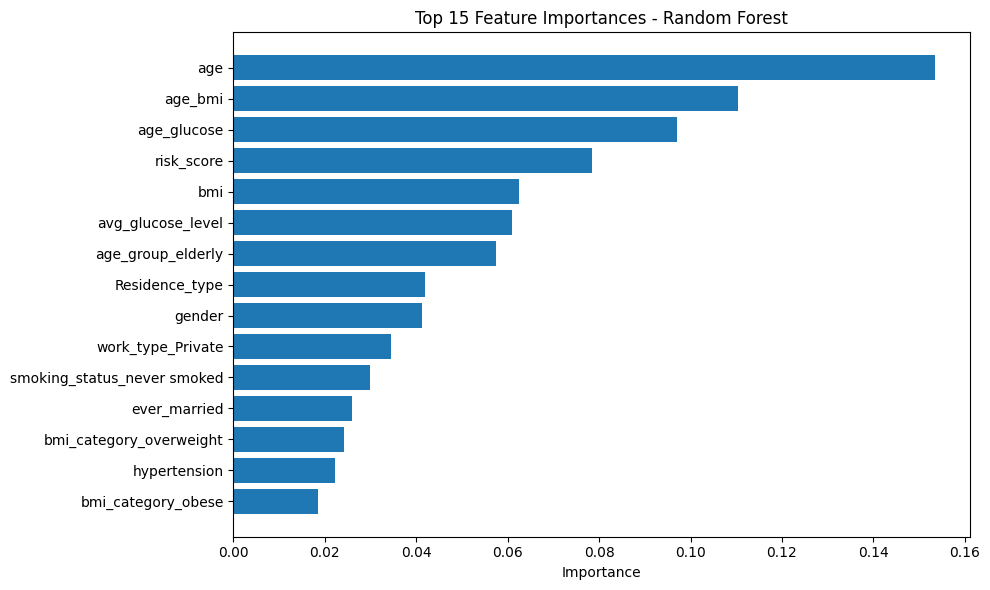

In [25]:
# feature importance
feature_importance_rf = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_tuned.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance_rf.head(10))

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_rf.head(15)['feature'], 
         feature_importance_rf.head(15)['importance'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

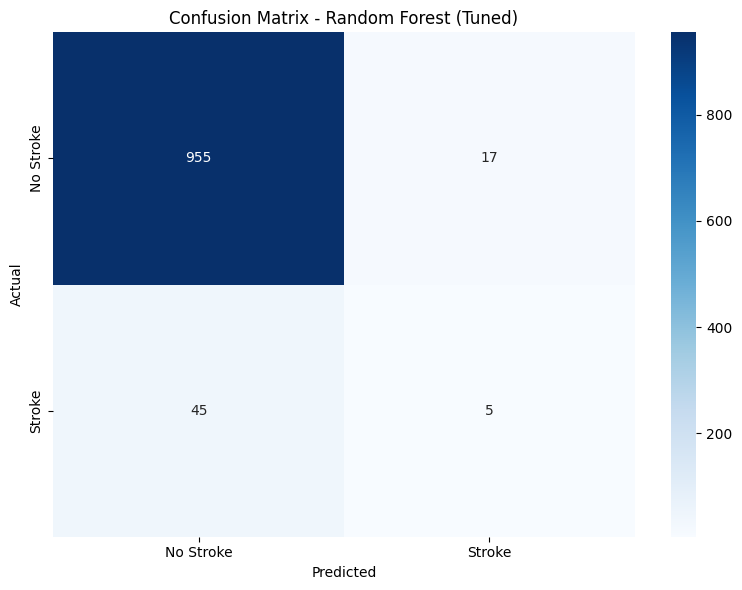

In [26]:
# confusion matrix
confusionMatrix_rf = confusion_matrix(y_test, y_pred_rf_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(confusionMatrix_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.title('Confusion Matrix - Random Forest (Tuned)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

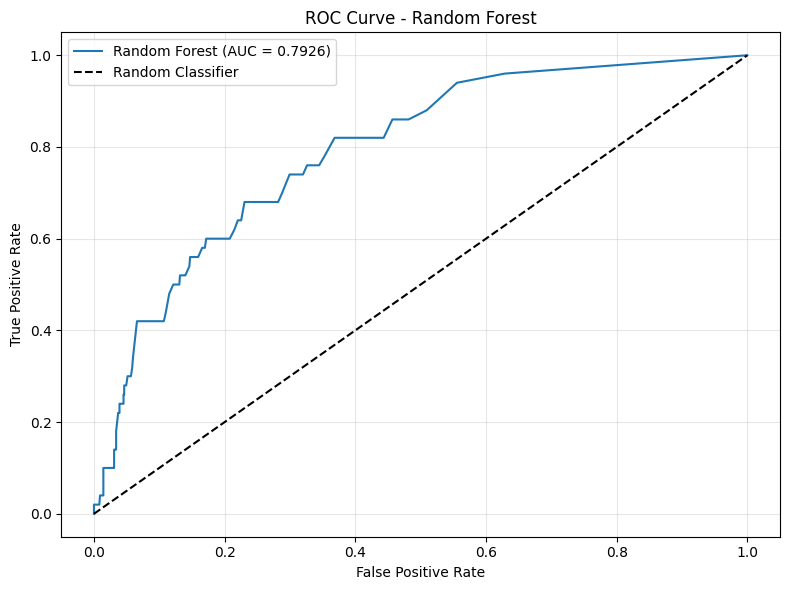

In [27]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf_tuned)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_pred_proba_rf_tuned):.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Class weights: {0: 1, 1: np.float64(19.537688442211056)}
Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5567 - auc: 0.6990 - loss: 1.2018 - precision: 0.0697 - recall: 0.6908 - val_accuracy: 0.7824 - val_auc: 0.7861 - val_loss: 1.2689 - val_precision: 0.1534 - val_recall: 0.6170 - learning_rate: 0.0010
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6733 - auc: 0.7872 - loss: 1.0309 - precision: 0.1038 - recall: 0.7895 - val_accuracy: 0.7751 - val_auc: 0.7864 - val_loss: 1.2055 - val_precision: 0.1451 - val_recall: 0.5957 - learning_rate: 0.0010
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6913 - auc: 0.7967 - loss: 1.0233 - precision: 0.1065 - recall: 0.7632 - val_accuracy: 0.7408 - val_auc: 0.7811 - val_loss: 1.2019 - val_precision: 0.1333 - val_recall: 0.6383 - learning_rate: 0.0010
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7048 - auc: 0.8363 - loss: 0.9184 - precision: 0.1190 - recall: 0.8355 - va

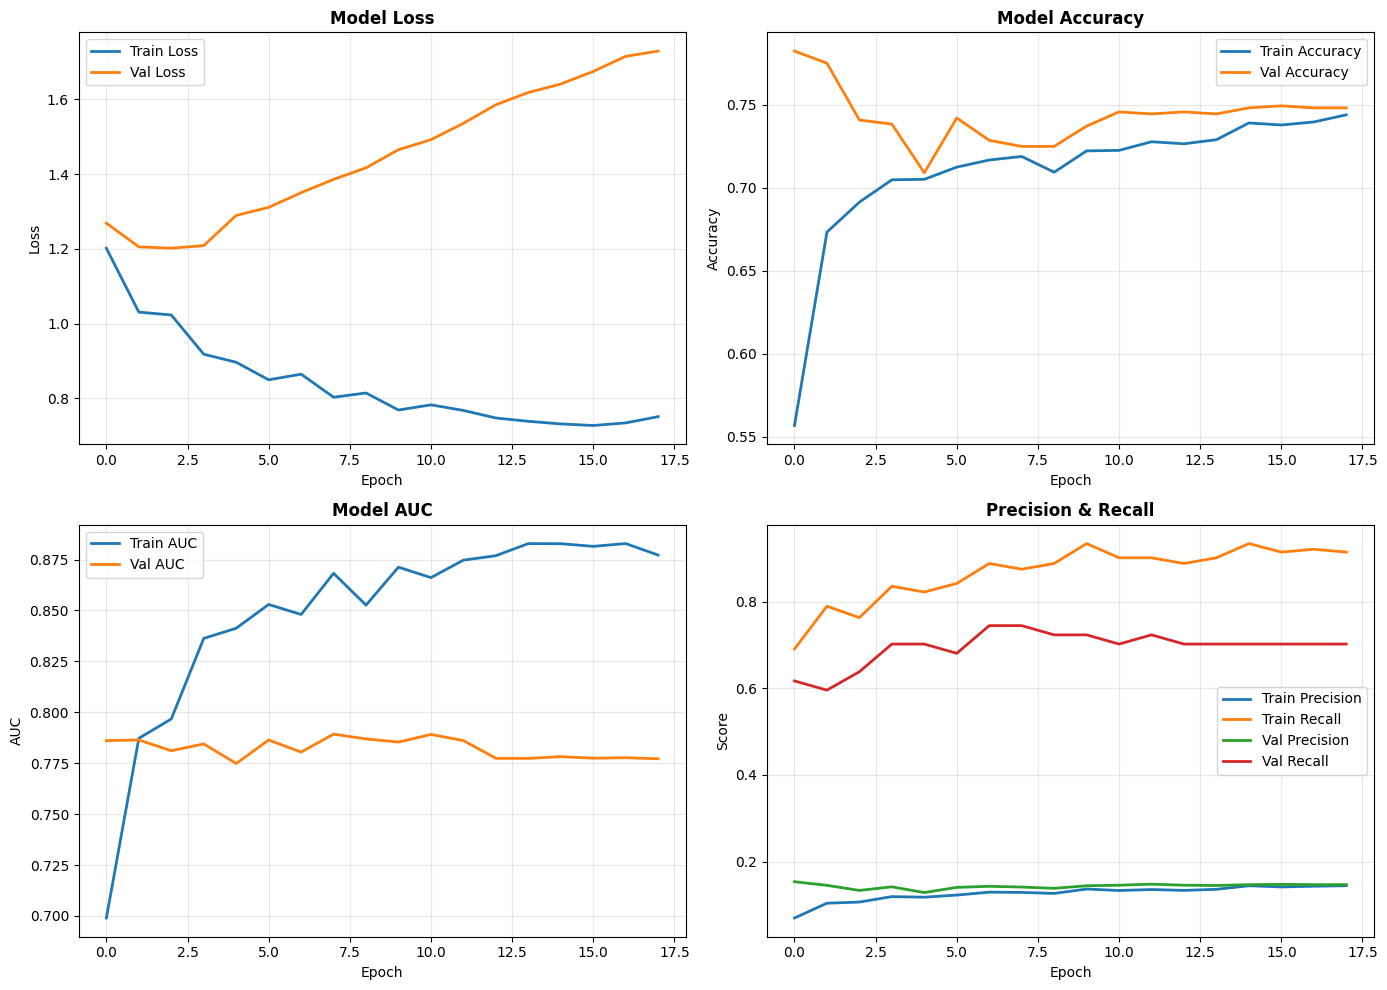

In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scikeras.wrappers import KerasClassifier
tf.random.set_seed(RANDOM_STATE)

def build_neural_network(meta,
                         hidden_1=128,
                         hidden_2=64,
                         hidden_3=32,
                         hidden_4=16,
                         dropout_1=0.3,
                         dropout_2=0.3,
                         dropout_3=0.2,
                         learning_rate=0.001):
    
    
    n_features = meta["n_features_in_"]
    
    model = keras.Sequential([
        # Input layer
        keras.layers.Input(shape=(n_features,)),
        
        # Hidden Layer 1
        keras.layers.Dense(hidden_1, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(dropout_1),
        
        # Hidden Layer 2
        keras.layers.Dense(hidden_2, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(dropout_2),
        
        # Hidden Layer 3
        keras.layers.Dense(hidden_3, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(dropout_3),
        
        # Hidden Layer 4
        keras.layers.Dense(hidden_4, activation='relu'),
        keras.layers.Dropout(dropout_3),
        
        # Output layer
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', 
                keras.metrics.AUC(name='auc'),
                keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall')]
    )
    return model


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)


class_weight = {0: 1, 1: (y_train == 0).sum() / (y_train == 1).sum()}
print(f"Class weights: {class_weight}")

nn_classifier = KerasClassifier(
    model=build_neural_network,
    # Architecture hyperparameters
    hidden_1=128,
    hidden_2=64,
    hidden_3=32,
    hidden_4=16,
    dropout_1=0.3,
    dropout_2=0.3,
    dropout_3=0.2,
    learning_rate=0.001,
    
    # Training hyperparameters
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weight,  # Handle class imbalance
    verbose=1,
    random_state=RANDOM_STATE
)

nn_classifier.fit(X_train_scaled, y_train) # no smote

y_pred_proba_nn = nn_classifier.predict_proba(X_test_scaled)[:, 1]
y_pred_nn = (y_pred_proba_nn > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_nn))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_nn):.4f}")


# Access training history
history = nn_classifier.history_

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss
axes[0, 0].plot(history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_title('Model Loss', fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Accuracy
axes[0, 1].plot(history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0, 1].plot(history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0, 1].set_title('Model Accuracy', fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# AUC
axes[1, 0].plot(history['a_u_c'], label='Train AUC', linewidth=2)
axes[1, 0].plot(history['val_auc'], label='Val AUC', linewidth=2)
axes[1, 0].set_title('Model AUC', fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUC')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Precision & Recall
axes[1, 1].plot(history['precision'], label='Train Precision', linewidth=2)
axes[1, 1].plot(history['recall'], label='Train Recall', linewidth=2)
axes[1, 1].plot(history['val_precision'], label='Val Precision', linewidth=2)
axes[1, 1].plot(history['val_recall'], label='Val Recall', linewidth=2)
axes[1, 1].set_title('Precision & Recall', fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [29]:
acc  = accuracy_score(y_test, y_pred_nn)
prec = precision_score(y_test, y_pred_nn, zero_division=0)
rec  = recall_score(y_test, y_pred_nn, zero_division=0)
f1   = f1_score(y_test, y_pred_nn, zero_division=0)
auc  = roc_auc_score(y_test, y_pred_proba_nn)

print("Neural Network Evaluation Metrics")
print("-" * 40)
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC-AUC  : {auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_nn, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nn))

Neural Network Evaluation Metrics
----------------------------------------
Accuracy : 0.7250
Precision: 0.1286
Recall   : 0.8000
F1-score : 0.2216
ROC-AUC  : 0.8176

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.72      0.83       972
           1       0.13      0.80      0.22        50

    accuracy                           0.73      1022
   macro avg       0.56      0.76      0.53      1022
weighted avg       0.94      0.73      0.80      1022

Confusion Matrix:
[[701 271]
 [ 10  40]]


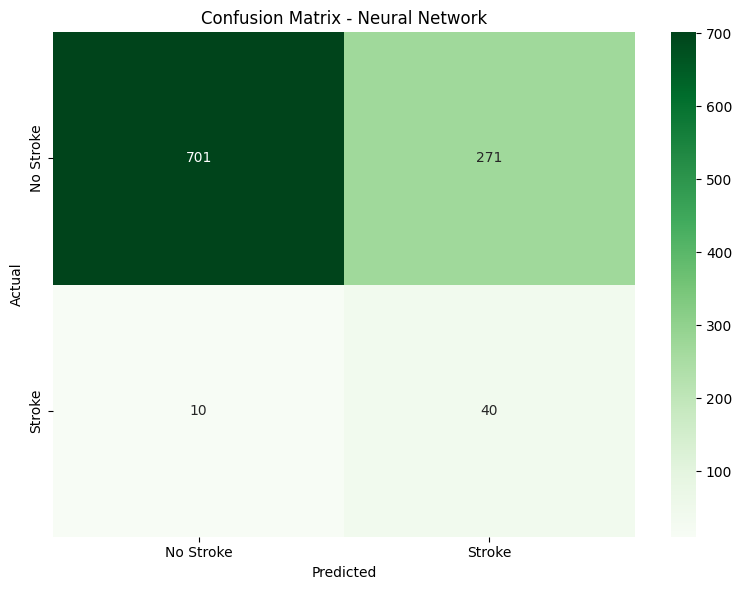

In [30]:
confusionMatrix_nn = confusion_matrix(y_test, y_pred_nn)
plt.figure(figsize=(8, 6))
sns.heatmap(confusionMatrix_nn, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.title('Confusion Matrix - Neural Network')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

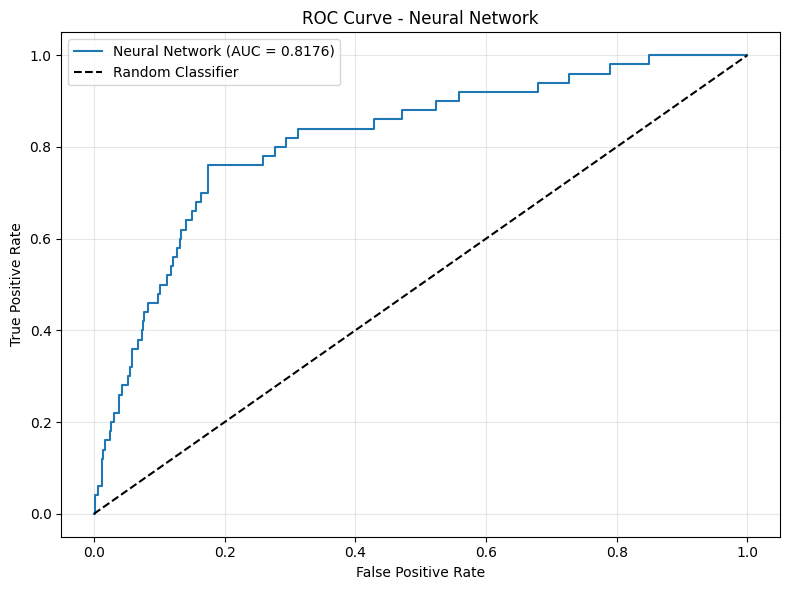

In [31]:
# roc curve for nn model
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_proba_nn)
plt.figure(figsize=(8, 6))
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {roc_auc_score(y_test, y_pred_proba_nn):.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Neural Network')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

MODEL COMPARISON

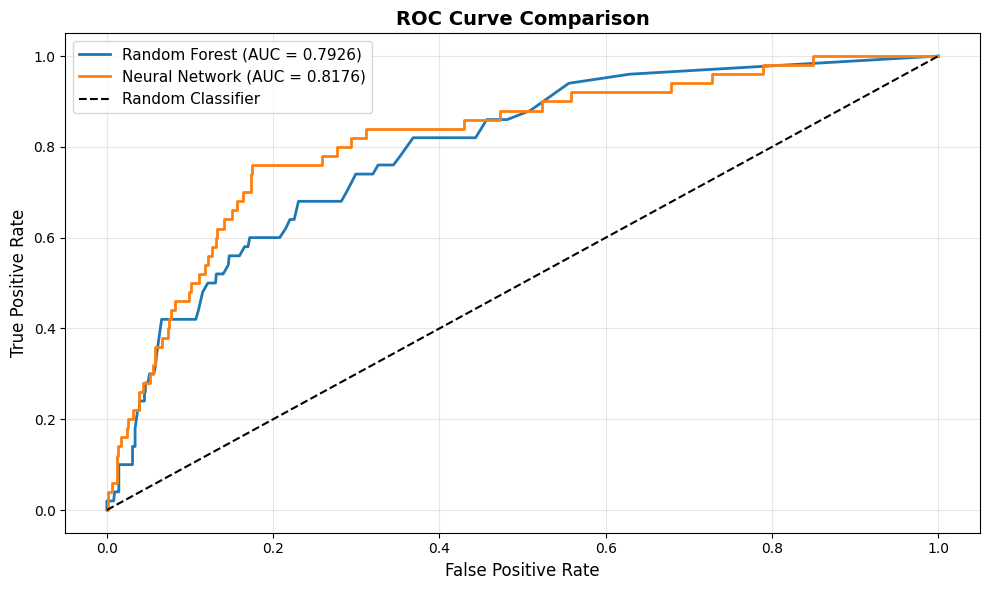


Metrics Comparison Table:
         Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
 Random Forest  0.939335   0.227273     0.1  0.138889 0.792572
Neural Network  0.725049   0.128617     0.8  0.221607 0.817593


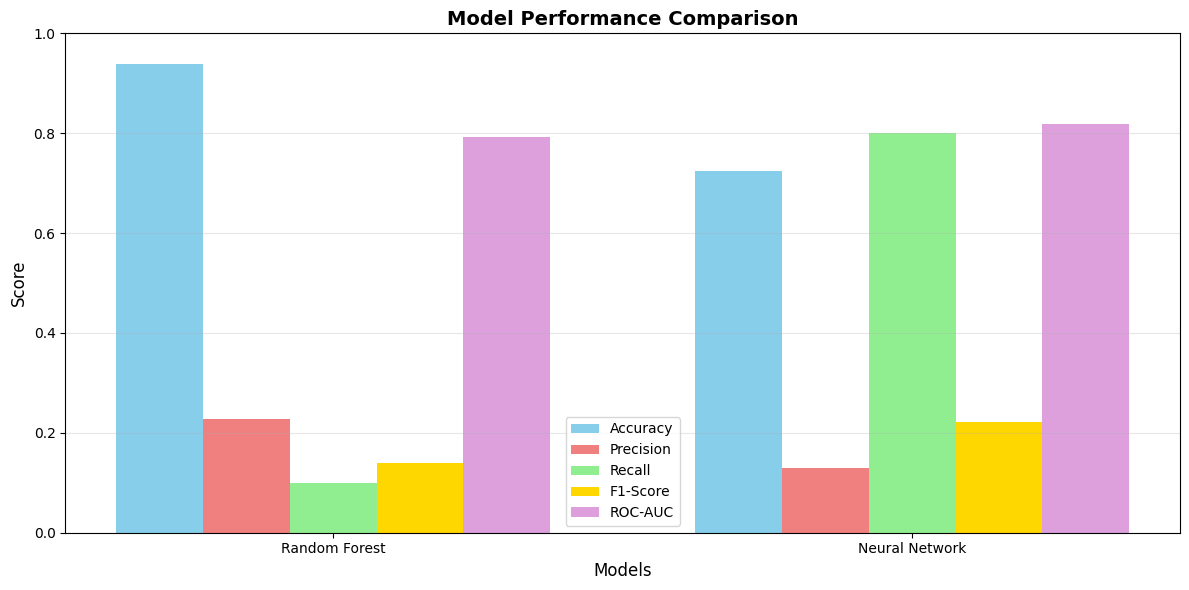

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_pred_proba_rf_tuned):.4f})', linewidth=2)
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {roc_auc_score(y_test, y_pred_proba_nn):.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# metrics comparison
models_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Neural Network'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_rf_tuned),
        accuracy_score(y_test, y_pred_nn)
    ],
    'Precision': [
        precision_score(y_test, y_pred_rf_tuned),
        precision_score(y_test, y_pred_nn)
    ],
    'Recall': [
        recall_score(y_test, y_pred_rf_tuned),
        recall_score(y_test, y_pred_nn)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_rf_tuned),
        f1_score(y_test, y_pred_nn)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_pred_proba_rf_tuned),
        roc_auc_score(y_test, y_pred_proba_nn)
    ]
})

print("\nMetrics Comparison Table:")
print(models_comparison.to_string(index=False))

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(models_comparison['Model']))
width = 0.15
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum']

for i, metric in enumerate(metrics):
    ax.bar(x + i*width, models_comparison[metric], width, label=metric, color=colors[i])

ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(models_comparison['Model'])
ax.legend()
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


MODEL EXPLANABILITY

<Figure size 1000x800 with 0 Axes>

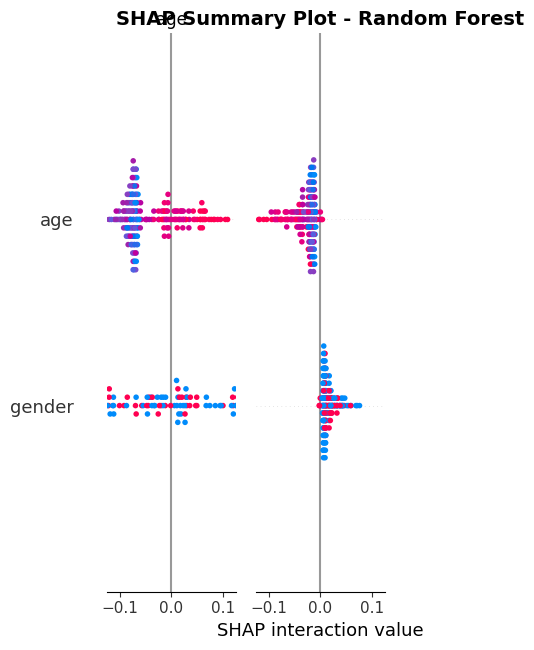

<Figure size 1000x600 with 0 Axes>

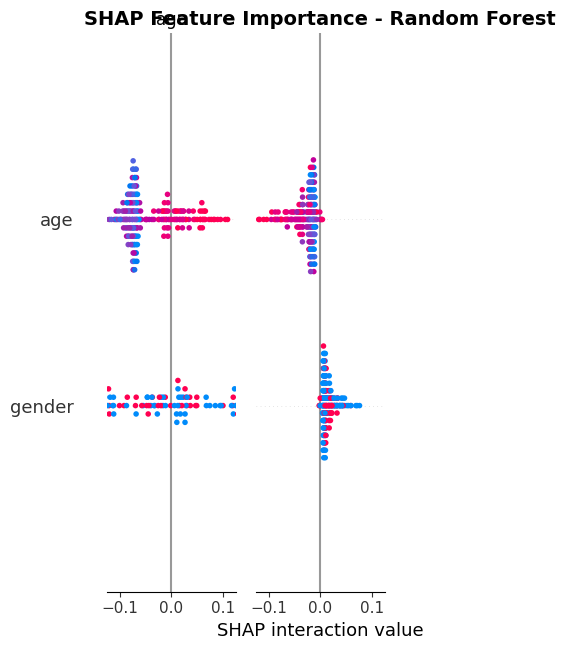

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


  2%|▏         | 1/50 [00:12<09:51, 12.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


  4%|▍         | 2/50 [00:24<09:43, 12.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


  6%|▌         | 3/50 [00:34<08:44, 11.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 6s 980us/step


  8%|▊         | 4/50 [00:42<07:44, 10.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 10%|█         | 5/50 [01:03<10:28, 13.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 12%|█▏        | 6/50 [01:12<08:59, 12.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 14%|█▍        | 7/50 [01:22<08:08, 11.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 6s 971us/step


 16%|█▌        | 8/50 [01:30<07:18, 10.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 18%|█▊        | 9/50 [01:40<06:56, 10.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 20%|██        | 10/50 [01:48<06:27,  9.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 6s 970us/step


 22%|██▏       | 11/50 [01:56<06:00,  9.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 6s 975us/step


 24%|██▍       | 12/50 [02:05<05:40,  8.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 26%|██▌       | 13/50 [02:13<05:28,  8.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 6s 909us/step


 28%|██▊       | 14/50 [02:21<05:08,  8.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 30%|███       | 15/50 [02:30<04:58,  8.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 7s 997us/step


 32%|███▏      | 16/50 [02:38<04:49,  8.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 6s 955us/step


 34%|███▍      | 17/50 [02:46<04:36,  8.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 7s 985us/step


 36%|███▌      | 18/50 [02:55<04:28,  8.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 38%|███▊      | 19/50 [03:04<04:27,  8.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 6s 958us/step


 40%|████      | 20/50 [03:12<04:15,  8.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 7s 985us/step


 42%|████▏     | 21/50 [03:21<04:07,  8.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 6s 952us/step


 44%|████▍     | 22/50 [03:29<03:55,  8.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 6s 906us/step


 46%|████▌     | 23/50 [03:37<03:42,  8.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 6s 948us/step


 48%|████▊     | 24/50 [03:45<03:38,  8.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 50%|█████     | 25/50 [03:54<03:34,  8.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 52%|█████▏    | 26/50 [04:03<03:25,  8.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 6s 946us/step


 54%|█████▍    | 27/50 [04:11<03:14,  8.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 56%|█████▌    | 28/50 [04:20<03:08,  8.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 58%|█████▊    | 29/50 [04:29<03:00,  8.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 60%|██████    | 30/50 [04:37<02:51,  8.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 62%|██████▏   | 31/50 [04:46<02:42,  8.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 64%|██████▍   | 32/50 [04:54<02:35,  8.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 6s 952us/step


 66%|██████▌   | 33/50 [05:03<02:23,  8.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 68%|██████▊   | 34/50 [05:11<02:16,  8.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 6s 967us/step


 70%|███████   | 35/50 [05:20<02:07,  8.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 6s 929us/step


 72%|███████▏  | 36/50 [05:28<01:56,  8.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 6s 907us/step


 74%|███████▍  | 37/50 [05:36<01:46,  8.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 6s 971us/step


 76%|███████▌  | 38/50 [05:44<01:38,  8.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 6s 901us/step


 78%|███████▊  | 39/50 [05:52<01:29,  8.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 6s 940us/step


 80%|████████  | 40/50 [06:00<01:20,  8.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 82%|████████▏ | 41/50 [06:09<01:15,  8.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 84%|████████▍ | 42/50 [06:18<01:08,  8.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 86%|████████▌ | 43/50 [06:26<00:59,  8.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 88%|████████▊ | 44/50 [06:35<00:51,  8.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 90%|█████████ | 45/50 [06:43<00:42,  8.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 92%|█████████▏| 46/50 [06:52<00:34,  8.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 94%|█████████▍| 47/50 [07:01<00:26,  8.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 96%|█████████▌| 48/50 [07:10<00:17,  8.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 98%|█████████▊| 49/50 [07:18<00:08,  8.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 7s 991us/step


100%|██████████| 50/50 [07:26<00:00,  8.94s/it]


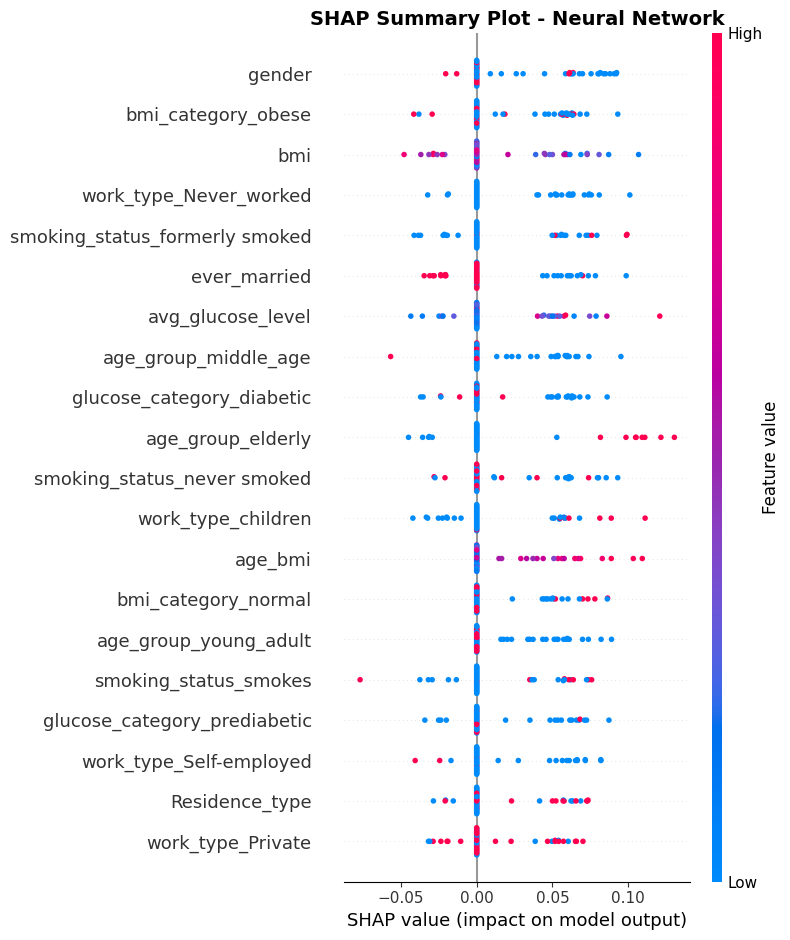

In [35]:
import shap
# SHAP for Random Forest
sample_size = min(200, len(X_test_scaled))
X_test_sample = X_test_scaled[:sample_size]
explainer_rf = shap.TreeExplainer(rf_tuned)
shap_values_rf = explainer_rf.shap_values(X_test_sample)
if isinstance(shap_values_rf, list):
    shap_to_plot = shap_values_rf[1]
else:
    shap_to_plot = shap_values_rf

assert len(feature_names) == X_test_sample.shape[1], \
    f"{len(feature_names)} names for {X_test_sample.shape[1]} columns."
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_to_plot, X_test_sample,
                  feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot - Random Forest", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_to_plot, X_test_sample,
                  feature_names=feature_names,
                  plot_type="bar", show=False)
plt.title("SHAP Feature Importance - Random Forest", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

# SHAP for Neural Network (KernelExplainer)
# smaller sample for speed
sample_size_nn = min(50, len(X_test_scaled))
X_test_sample_nn = X_test_scaled[:sample_size_nn]

background = X_train_scaled[:100]

def nn_predict_proba_positive(x):
    proba = nn_classifier.predict_proba(x)
    proba = np.array(proba)
    if proba.ndim == 2:
        if proba.shape[1] == 2:
            return proba[:, 1]
        else:
            return proba[:, 0]
    return proba

explainer_nn = shap.KernelExplainer(nn_predict_proba_positive, background)
shap_values_nn = explainer_nn.shap_values(X_test_sample_nn)

if isinstance(shap_values_nn, list):
    shap_values_nn = shap_values_nn[0]

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_nn, X_test_sample_nn,
                  feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot - Neural Network", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()



Random Forest - 5-Fold CV ROC-AUC Scores: [0.98461879 0.99770025 0.99640401 0.99828786 0.99802649]
Mean: 0.9950 (+/- 0.0105)


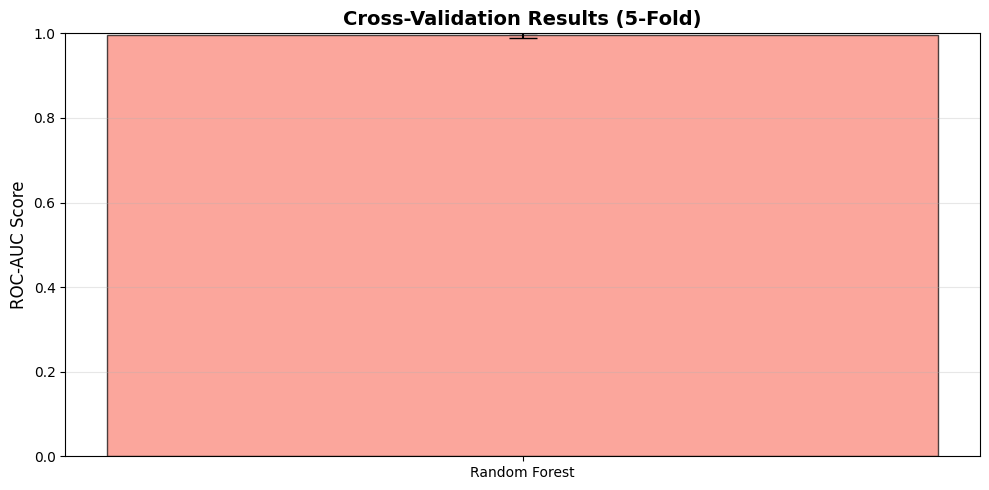

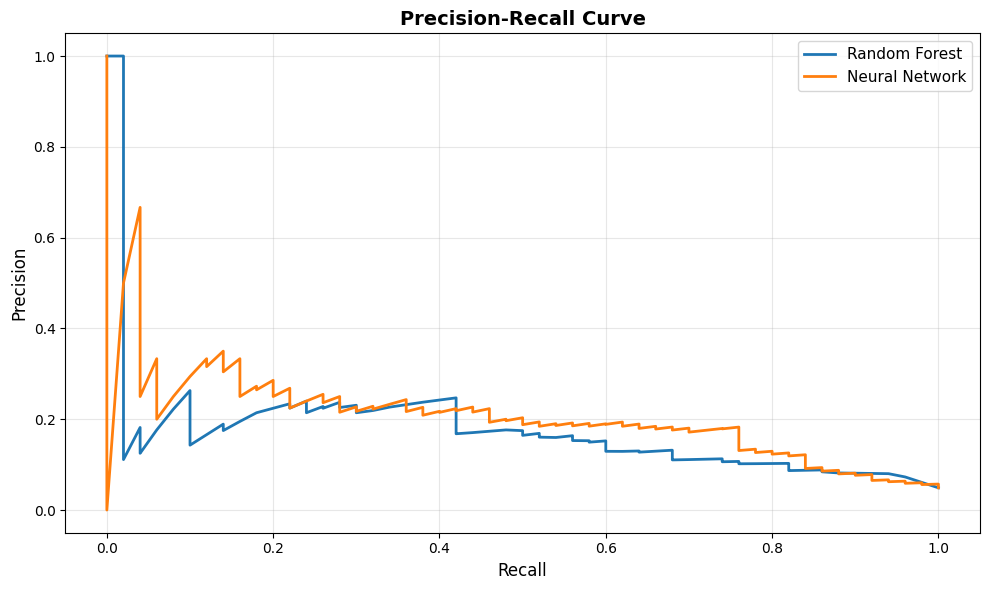

In [36]:
# cross-validation analysis (random forest)
cv_scores_rf = cross_val_score(rf_tuned, X_train_balanced, y_train_balanced, 
                                cv=5, scoring='roc_auc', n_jobs=-1)
print(f"\nRandom Forest - 5-Fold CV ROC-AUC Scores: {cv_scores_rf}")
print(f"Mean: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std() * 2:.4f})")

fig, ax = plt.subplots(figsize=(10, 5))
models_cv = ['Random Forest']
cv_means = [cv_scores_rf.mean()]
cv_stds = [cv_scores_rf.std()]

x_pos = np.arange(len(models_cv))
ax.bar(x_pos, cv_means, yerr=cv_stds, alpha=0.7, color='salmon', 
       capsize=10, edgecolor='black')
ax.set_ylabel('ROC-AUC Score', fontsize=12)
ax.set_title('Cross-Validation Results (5-Fold)', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(models_cv)
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


# precision recall curve
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf_tuned)
precision_nn, recall_nn, _ = precision_recall_curve(y_test, y_pred_proba_nn)

plt.figure(figsize=(10, 6))
plt.plot(recall_rf, precision_rf, label='Random Forest', linewidth=2)
plt.plot(recall_nn, precision_nn, label='Neural Network', linewidth=2)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [37]:
# ensemble model
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier

xgb_ens = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    use_label_encoder=False
)

rf_ens = rf_tuned

ensemble_model = VotingClassifier(
    estimators=[
        ('rf', rf_ens),
        ('xgb', xgb_ens)
    ],
    voting='soft'
)

print("\nTraining Ensemble model on SMOTE-balanced data...")
ensemble_model.fit(X_train_balanced, y_train_balanced)

y_pred_ensemble = ensemble_model.predict(X_test_scaled)
y_pred_proba_ensemble = ensemble_model.predict_proba(X_test_scaled)[:, 1]

print("\nEnsemble Model Results:")
print(classification_report(y_test, y_pred_ensemble))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_ensemble):.4f}")



Training Ensemble model on SMOTE-balanced data...

Ensemble Model Results:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       972
           1       0.19      0.10      0.13        50

    accuracy                           0.94      1022
   macro avg       0.57      0.54      0.55      1022
weighted avg       0.92      0.94      0.93      1022

ROC-AUC Score: 0.8017



Final Metrics Comparison:
         Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
 Random Forest  0.939335   0.227273     0.1  0.138889 0.792572
Neural Network  0.725049   0.128617     0.8  0.221607 0.817593
      Ensemble  0.935421   0.192308     0.1  0.131579 0.801708


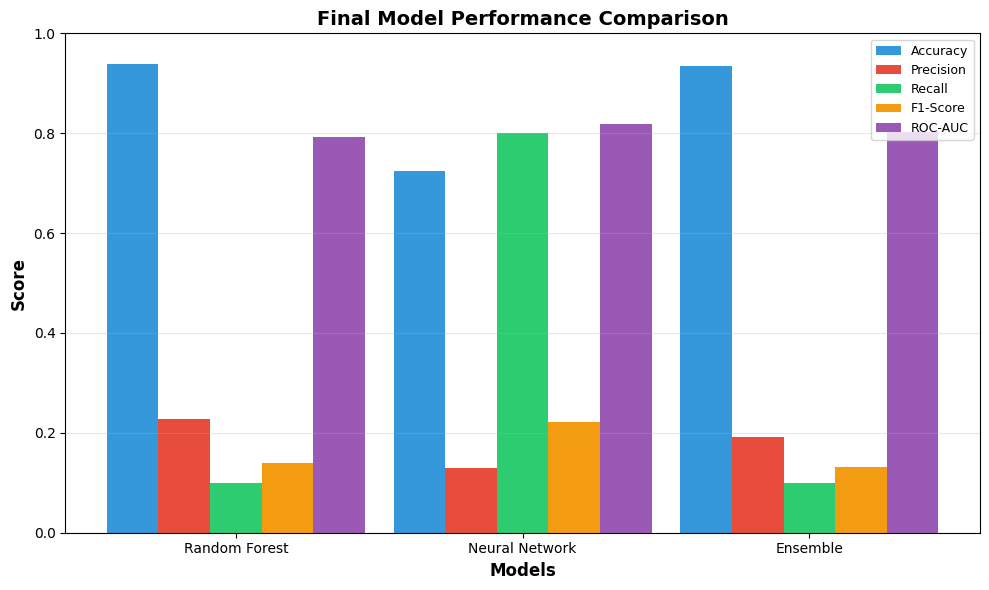

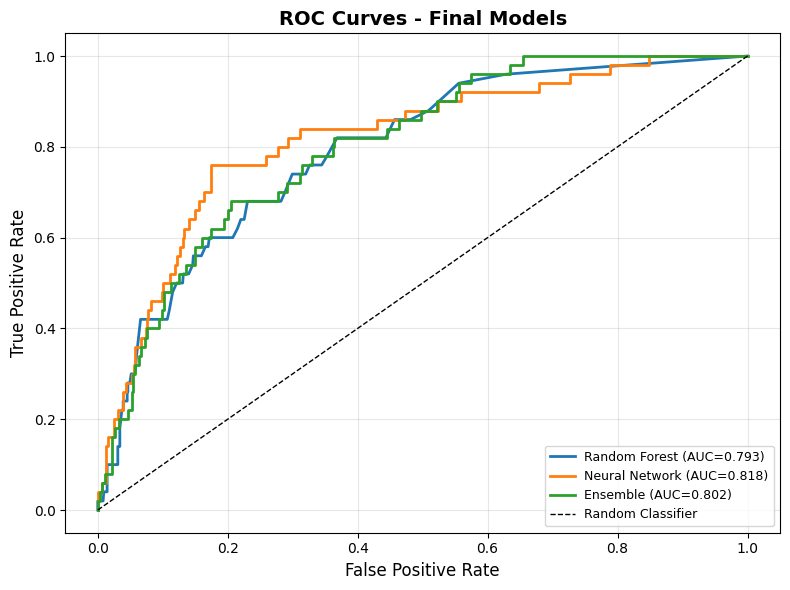

In [38]:
final_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Neural Network', 'Ensemble'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_rf_tuned),
        accuracy_score(y_test, y_pred_nn),
        accuracy_score(y_test, y_pred_ensemble)
    ],
    'Precision': [
        precision_score(y_test, y_pred_rf_tuned, zero_division=0),
        precision_score(y_test, y_pred_nn, zero_division=0),
        precision_score(y_test, y_pred_ensemble, zero_division=0)
    ],
    'Recall': [
        recall_score(y_test, y_pred_rf_tuned, zero_division=0),
        recall_score(y_test, y_pred_nn, zero_division=0),
        recall_score(y_test, y_pred_ensemble, zero_division=0)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_rf_tuned, zero_division=0),
        f1_score(y_test, y_pred_nn, zero_division=0),
        f1_score(y_test, y_pred_ensemble, zero_division=0)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_pred_proba_rf_tuned),
        roc_auc_score(y_test, y_pred_proba_nn),
        roc_auc_score(y_test, y_pred_proba_ensemble)
    ]
})

print("\nFinal Metrics Comparison:")
print(final_comparison.to_string(index=False))


fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(final_comparison['Model']))
width = 0.18
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

for i, metric in enumerate(metrics):
    ax.bar(x + i*width, final_comparison[metric], width,
           label=metric, color=colors[i])

ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Final Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(final_comparison['Model'], fontsize=10)
ax.legend(fontsize=9)
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


from sklearn.metrics import roc_curve

plt.figure(figsize=(8, 6))

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf_tuned)
plt.plot(fpr_rf, tpr_rf,
         label=f'Random Forest (AUC={roc_auc_score(y_test, y_pred_proba_rf_tuned):.3f})',
         linewidth=2)

# Neural Network
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_proba_nn)
plt.plot(fpr_nn, tpr_nn,
         label=f'Neural Network (AUC={roc_auc_score(y_test, y_pred_proba_nn):.3f})',
         linewidth=2)

# Ensemble
fpr_ens, tpr_ens, _ = roc_curve(y_test, y_pred_proba_ensemble)
plt.plot(fpr_ens, tpr_ens,
         label=f'Ensemble (AUC={roc_auc_score(y_test, y_pred_proba_ensemble):.3f})',
         linewidth=2)

# Random baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Final Models', fontsize=14, fontweight='bold')
plt.legend(fontsize=9, loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()